In [1]:
# http://www.blackarbs.com/blog/time-series-analysis-in-python-linear-models-to-garch/11/1/2016

In [32]:
# Part 2
import warnings
warnings.filterwarnings("ignore")

In [3]:
import os
import sys

import pandas as pd
#import pandas_datareader.data as web
import numpy as np

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from arch import arch_model

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

In [4]:
# read the data

In [5]:
spy = pd.read_csv('SPY.csv', parse_dates = ['Date'])
spy = spy[['Date', 'Close']]
spy.columns = ['Date', 'SPY']
spy = spy.set_index('Date')
spy.head()

,SPY
Date,
2007-01-03,141.369995
2007-01-04,141.669998
2007-01-05,140.539993
2007-01-08,141.190002
2007-01-09,141.070007


In [6]:
msft = pd.read_csv('MSFT.csv', parse_dates = ['Date'])


In [7]:
msft = msft[['Date', 'Close']]

In [8]:
msft.columns = ['Date', 'MSFT']


In [9]:
msft = msft.set_index('Date')
msft.head()

,MSFT
Date,
2007-01-03,29.860001
2007-01-04,29.809999
2007-01-05,29.639999
2007-01-08,29.930000
2007-01-09,29.959999


In [10]:
tlt = pd.read_csv('TLT.csv', parse_dates = ['Date'])
tlt = tlt[['Date', 'Close']]
tlt.columns = ['Date', 'TLT']
tlt = tlt.set_index('Date')
tlt.head()

,TLT
Date,
2007-01-03,89.059998
2007-01-04,89.599998
2007-01-05,89.209999
2007-01-08,89.370003
2007-01-09,89.370003


In [13]:
# combine data
data = spy.join(msft, how = 'inner').join(tlt, how = 'inner')

In [14]:
data.head()

,SPY,MSFT,TLT
Date,,,
2007-01-03,141.369995,29.860001,89.059998
2007-01-04,141.669998,29.809999,89.599998
2007-01-05,140.539993,29.639999,89.209999
2007-01-08,141.190002,29.930000,89.370003
2007-01-09,141.070007,29.959999,89.370003


In [18]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

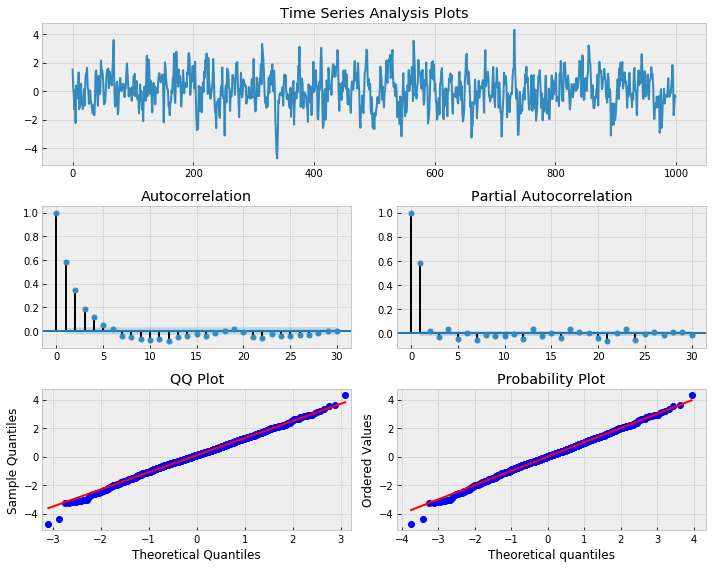

In [19]:
# Simulate an AR(1) process with alpha = 0.6
lags = 30
np.random.seed(1)
n_samples = int(1000)
a = 0.6
x = w = np.random.normal(size=n_samples)

for t in range(n_samples):
    x[t] = a*x[t-1] + w[t]
    
_ = tsplot(x, lags=lags)

In [22]:
# Fit an AR(p) model to simulated AR(1) model with alpha = 0.6

mdl = smt.AR(x).fit(maxlag=30, ic='aic', trend='nc')
%time est_order = smt.AR(x).select_order(maxlag=30, ic='aic', trend='nc')

true_order = 1
print('\nalpha estimate: {:3.5f} | best lag order = {}'
  .format(mdl.params[0], est_order))
print('\ntrue alpha = {} | true order = {}'
  .format(a, true_order))

Wall time: 14.2 s

alpha estimate: 0.58227 | best lag order = 1

true alpha = 0.6 | true order = 1


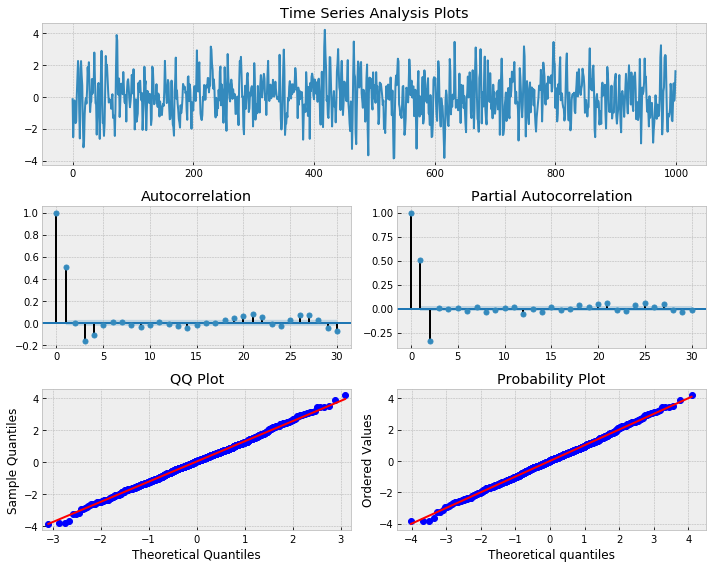

In [23]:
# Simulate an AR(2) process

n = int(1000)
alphas = np.array([.666, -.333])
betas = np.array([0.])

# Python requires us to specify the zero-lag value which is 1
# Also note that the alphas for the AR model must be negated
# We also set the betas for the MA equal to 0 for an AR(p) model
# For more information see the examples at statsmodels.org
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

ar2 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n) 
_ = tsplot(ar2, lags=lags)

In [24]:
# Fit an AR(p) model to simulated AR(2) process

max_lag = 10
mdl = smt.AR(ar2).fit(maxlag=max_lag, ic='aic', trend='nc')
est_order = smt.AR(ar2).select_order(
    maxlag=max_lag, ic='aic', trend='nc')

true_order = 2
print('\ncoef estimate: {:3.4f} {:3.4f} | best lag order = {}'
  .format(mdl.params[0],mdl.params[1], est_order))
print('\ntrue coefs = {} | true order = {}'
  .format([.666,-.333], true_order))
  
# coef estimate: 0.6291 -0.3196 | best lag order = 2
# true coefs = [0.666, -0.333] | true order = 2


coef estimate: 0.6760 -0.3393 | best lag order = 2

true coefs = [0.666, -0.333] | true order = 2


In [25]:
# Moving Average Models - MA(q)

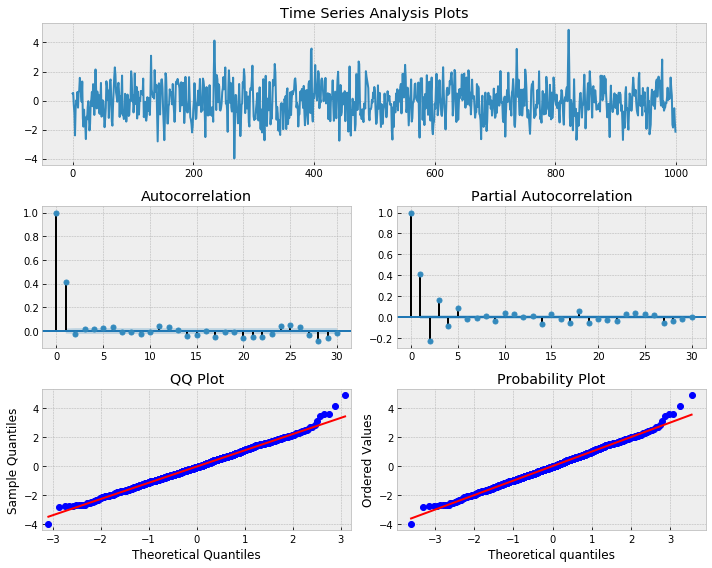

In [26]:
# Simulate an MA(1) process

n = int(1000)

# set the AR(p) alphas equal to 0
alphas = np.array([0.])
betas = np.array([0.6])

# add zero-lag and negate alphas
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

ma1 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n) 
_ = tsplot(ma1, lags=30)

In [27]:
# Fit the MA(1) model to our simulated time series
# Specify ARMA model with order (p, q)

max_lag = 30
mdl = smt.ARMA(ma1, order=(0, 1)).fit(maxlag=max_lag, method='mle', trend='nc')
print(mdl.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1000
Model:                     ARMA(0, 1)   Log Likelihood               -1390.513
Method:                           mle   S.D. of innovations              0.972
Date:                Tue, 20 Aug 2019   AIC                           2785.025
Time:                        17:17:05   BIC                           2794.841
Sample:                             0   HQIC                          2788.756
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1.y        0.5874      0.026     22.762      0.000       0.537       0.638
                                    Roots                                    
                  Real          Imaginary           M

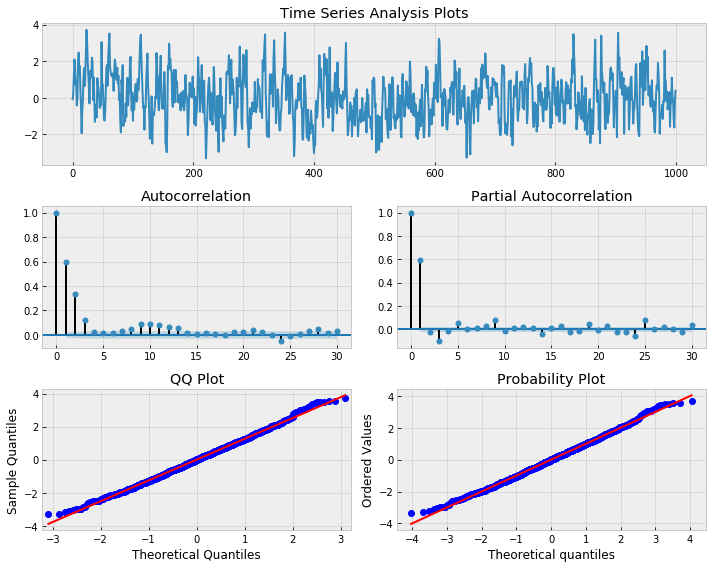

In [28]:
# Simulate MA(3) process with betas 0.6, 0.4, 0.2

n = int(1000)
alphas = np.array([0.])
betas = np.array([0.6, 0.4, 0.2])
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

ma3 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n)
_ = tsplot(ma3, lags=30)

In [29]:
# Fit MA(3) model to simulated time series

max_lag = 30
mdl = smt.ARMA(ma3, order=(0, 3)).fit(
    maxlag=max_lag, method='mle', trend='nc')
print(mdl.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1000
Model:                     ARMA(0, 3)   Log Likelihood               -1427.038
Method:                           mle   S.D. of innovations              1.008
Date:                Tue, 20 Aug 2019   AIC                           2862.075
Time:                        17:18:10   BIC                           2881.706
Sample:                             0   HQIC                          2869.536
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1.y        0.6025      0.031     19.322      0.000       0.541       0.664
ma.L2.y        0.4060      0.034     11.806      0.000       0.339       0.473
ma.L3.y        0.1683      0.031      5.420      0.0

In [30]:
# log returns
lrets = np.log(data/data.shift(1)).dropna()

                              ARMA Model Results                              
Dep. Variable:                    SPY   No. Observations:                 3019
Model:                     ARMA(0, 3)   Log Likelihood                8974.627
Method:                           mle   S.D. of innovations              0.012
Date:                Tue, 20 Aug 2019   AIC                         -17941.254
Time:                        17:21:13   BIC                         -17917.203
Sample:                             0   HQIC                        -17932.605
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1.SPY     -0.0818      0.018     -4.503      0.000      -0.117      -0.046
ma.L2.SPY     -0.0721      0.019     -3.879      0.000      -0.108      -0.036
ma.L3.SPY      0.0222      0.018      1.238      0.2

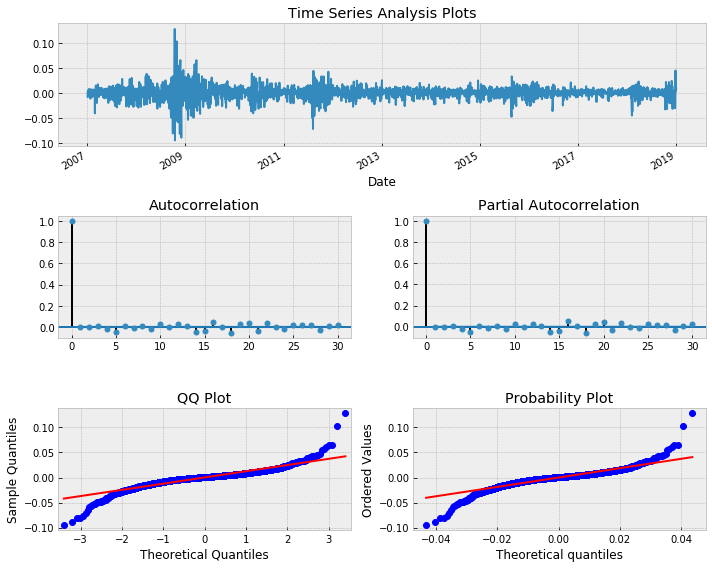

In [33]:
# Fit MA(3) to SPY returns

max_lag = 30
Y = lrets.SPY
mdl = smt.ARMA(Y, order=(0, 3)).fit(maxlag=max_lag, method='mle', trend='nc')
print(mdl.summary())
_ = tsplot(mdl.resid, lags=max_lag)

In [34]:
# Autoregressive Moving Average Models - ARMA(p, q)

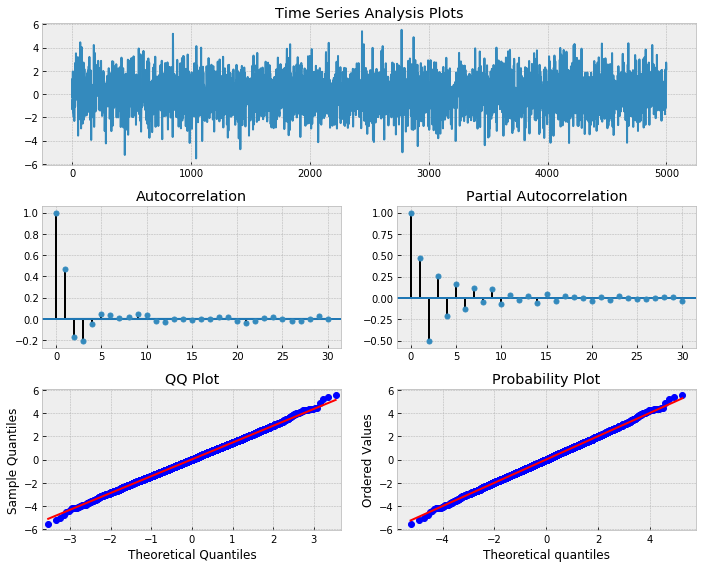

In [35]:
# Simulate an ARMA(2, 2) model with alphas=[0.5,-0.25] and betas=[0.5,-0.3]
max_lag = 30

n = int(5000) # lots of samples to help estimates
burn = int(n/10) # number of samples to discard before fit

alphas = np.array([0.5, -0.25])
betas = np.array([0.5, -0.3])
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

arma22 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n, burnin=burn)
_ = tsplot(arma22, lags=max_lag)

In [36]:
# fit the model
mdl = smt.ARMA(arma22, order=(2, 2)).fit(maxlag=max_lag, method='mle', trend='nc', burnin=burn)
print(mdl.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 5000
Model:                     ARMA(2, 2)   Log Likelihood               -7076.176
Method:                           mle   S.D. of innovations              0.996
Date:                Tue, 20 Aug 2019   AIC                          14162.352
Time:                        17:24:01   BIC                          14194.938
Sample:                             0   HQIC                         14173.773
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.y        0.4730      0.051      9.338      0.000       0.374       0.572
ar.L2.y       -0.2645      0.015    -17.489      0.000      -0.294      -0.235
ma.L1.y        0.5224      0.052     10.089      0.0

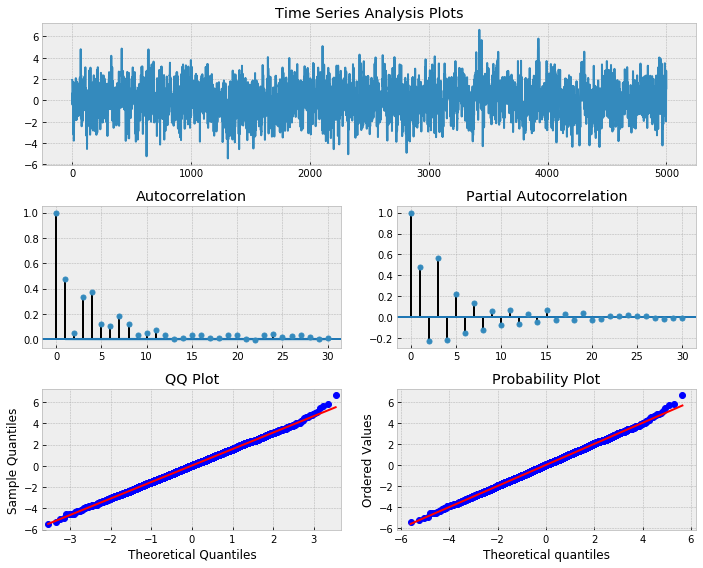

In [37]:
# Simulate an ARMA(3, 2) model with alphas=[0.5,-0.25,0.4] and betas=[0.5,-0.3]

max_lag = 30

n = int(5000)
burn = 2000

alphas = np.array([0.5, -0.25, 0.4])
betas = np.array([0.5, -0.3])

ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

arma32 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n, burnin=burn)
_ = tsplot(arma32, lags=max_lag)

In [38]:
# pick best order by aic 
# smallest aic value wins
best_aic = np.inf 
best_order = None
best_mdl = None

rng = range(5)
for i in rng:
    for j in rng:
        try:
            tmp_mdl = smt.ARMA(arma32, order=(i, j)).fit(method='mle', trend='nc')
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, j)
                best_mdl = tmp_mdl
        except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

# aic: 14108.27213 | order: (3, 2)

aic: 14212.01026 | order: (3, 2)


In [39]:
# Fit ARMA model to SPY returns - different data, different model

best_aic = np.inf 
best_order = None
best_mdl = None

rng = range(5) # [0,1,2,3,4,5]
for i in rng:
    for j in rng:
        try:
            tmp_mdl = smt.ARMA(lrets['SPY'], order=(i, j)).fit(
                method='mle', trend='nc'
            )
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, j)
                best_mdl = tmp_mdl
        except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

# aic: -11518.22902 | order: (4, 4)

aic: -17962.55266 | order: (3, 3)


In [40]:
# Autoregressive Integrated Moving Average Models - ARIMA(p, d, q)

In [41]:
# The pandas functions DataFrame.diff()/Series.diff() only takes the first difference of a dataframe/series and 
# does not implement the recursive differencing needed in TSA.  

In [42]:
# Fit ARIMA(p, d, q) model to SPY Returns
# pick best order and final model based on aic

best_aic = np.inf 
best_order = None
best_mdl = None

pq_rng = range(5) # [0,1,2,3,4]
d_rng = range(2) # [0,1]
for i in pq_rng:
    for d in d_rng:
        for j in pq_rng:
            try:
                tmp_mdl = smt.ARIMA(lrets.SPY, order=(i,d,j)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))
# aic: -11518.22902 | order: (4, 0, 4)

aic: -17962.55266 | order: (3, 0, 3)


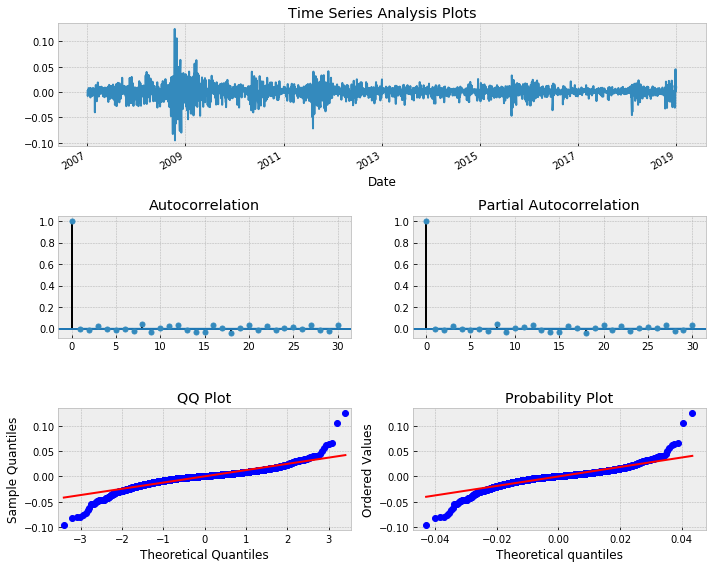

In [43]:
# ARIMA model resid plot
_ = tsplot(best_mdl.resid, lags=30)

In [45]:
# Create a 21 day forecast of SPY returns with 95%, 99% CI
n_steps = 21

f, err95, ci95 = best_mdl.forecast(steps=n_steps) # 95% CI
_, err99, ci99 = best_mdl.forecast(steps=n_steps, alpha=0.01) # 99% CI

idx = pd.date_range(data.index[-1], periods=n_steps, freq='D')
fc_95 = pd.DataFrame(np.column_stack([f, ci95]), 
                     index=idx, columns=['forecast', 'lower_ci_95', 'upper_ci_95'])
fc_99 = pd.DataFrame(np.column_stack([ci99]), 
                     index=idx, columns=['lower_ci_99', 'upper_ci_99'])
fc_all = fc_95.combine_first(fc_99)
fc_all.head()

,forecast,lower_ci_95,lower_ci_99,upper_ci_95,upper_ci_99
2018-12-31,0.000762,-0.023392,-0.030982,0.024916,0.032506
2019-01-01,-0.002260,-0.026494,-0.034109,0.021975,0.029590
2019-01-02,-0.000914,-0.025185,-0.032812,0.023358,0.030984
2019-01-03,0.001834,-0.022437,-0.030064,0.026106,0.033733
2019-01-04,-0.001039,-0.025313,-0.032941,0.023235,0.030862


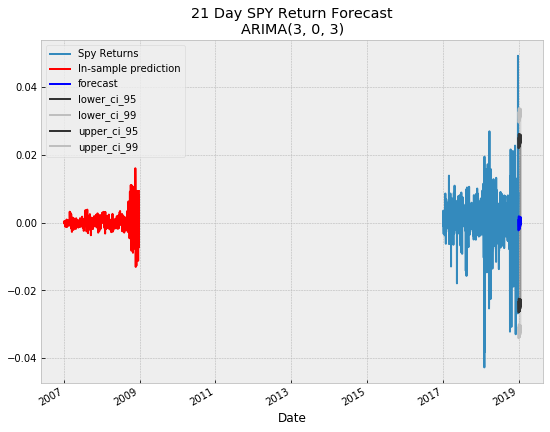

In [53]:
# Plot 21 day forecast for SPY returns
# need to fix
plt.style.use('bmh')
fig = plt.figure(figsize=(9,7))
ax = plt.gca()

ts = lrets.SPY.iloc[-500:].copy()
ts.plot(ax=ax, label='Spy Returns')

# in sample prediction
# pred = best_mdl.predict(ts.index[0], ts.index[-1])
pred = best_mdl.predict(0, len(ts)-1)
pred.plot(ax=ax, style='r-', label='In-sample prediction')

styles = ['b-', '0.2', '0.75', '0.2', '0.75']
fc_all.plot(ax=ax, style=styles)
plt.fill_between(fc_all.index, fc_all.lower_ci_95, fc_all.upper_ci_95, color='gray', alpha=0.7)
plt.fill_between(fc_all.index, fc_all.lower_ci_99, fc_all.upper_ci_99, color='gray', alpha=0.2)
plt.title('{} Day SPY Return Forecast\nARIMA{}'.format(n_steps, best_order))
plt.legend(loc='best', fontsize=10)

In [44]:
# http://www.blackarbs.com/blog/time-series-analysis-in-python-linear-models-to-garch/11/1/2016